In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import casadi as ca
import cyecca.lie as lie
from cyecca.lie.group_so3 import SO3Quat, SO3EulerB321, so3, SO3Dcm
from cyecca.lie.group_se23 import SE23Quat, se23
from scipy.spatial.transform import Rotation

# MCAP/ROS bag reading imports
try:
    import rclpy
    from rclpy.serialization import deserialize_message
    from rosbag2_py import SequentialReader, StorageOptions, ConverterOptions
    from nav_msgs.msg import Odometry
    from sensor_msgs.msg import Imu, MagneticField
    MCAP_AVAILABLE = True
    print("MCAP reading libraries available")
except ImportError as e:
    MCAP_AVAILABLE = False
    print(f"MCAP reading libraries not available: {e}")
    print("Please install: pip install ros2bag rosbag2-py")

# Set up plotting
try:
    plt.style.use('seaborn-v0_8')
except:
    try:
        plt.style.use('seaborn')  # fallback for older versions
    except:
        pass  # use default style if seaborn not available
plt.rcParams['figure.figsize'] = (12, 8)


MCAP reading libraries available


In [2]:
# Constants
g = 9.8  # gravity acceleration m/s^2

def angle_wrap(angle):
    """Wrap angle to [-pi, pi]"""
    wrapped = ca.fmod(angle, 2 * ca.pi)
    wrapped = ca.if_else(wrapped < 0, wrapped + 2 * ca.pi, wrapped)
    return ca.if_else(wrapped > ca.pi, wrapped - 2 * ca.pi, wrapped)

def quat_to_euler(q):
    """Convert quaternion [w,x,y,z] to Euler angles [roll,pitch,yaw]"""
    r = Rotation.from_quat([q[1], q[2], q[3], q[0]])  # scipy uses [x,y,z,w]
    return r.as_euler('xyz', degrees=True)  # roll, pitch, yaw in degrees


In [3]:
def read_mcap_data(mcap_file_path, odom_topic="/odom", imu_topic="/imu", mag_topic="/mag"):
    """Read IMU, magnetometer, and true attitude data from MCAP file.
    
    Args:
        mcap_file_path: Path to the MCAP file
        odom_topic: Odometry topic name (true attitude)
        imu_topic: IMU topic name
        mag_topic: Magnetometer topic name
        
    Returns:
        Tuple of (imu_df, mag_df, odom_df) DataFrames
    """
    if not MCAP_AVAILABLE:
        print("MCAP libraries not available")
        return None, None, None
        
    try:
        # Set up MCAP reader
        storage_options = StorageOptions(uri=mcap_file_path, storage_id='mcap')
        converter_options = ConverterOptions(input_serialization_format='cdr', output_serialization_format='cdr')
        
        reader = SequentialReader()
        reader.open(storage_options, converter_options)
        
        # Storage for data
        imu_data = []
        mag_data = []
        odom_data = []
        
        print(f"Reading data from {mcap_file_path}")
        print(f"Looking for topics: {odom_topic}, {imu_topic}, {mag_topic}")
        
        msg_count = 0
        while reader.has_next():
            current_topic, msg_data, _ = reader.read_next()
            msg_count += 1
            
            if msg_count % 1000 == 0:
                print(f"Processed {msg_count} messages...")
            
            if current_topic == odom_topic:
                # Deserialize odometry message
                msg = deserialize_message(msg_data, Odometry)
                
                # Extract position
                pos = msg.pose.pose.position
                
                # Extract orientation (quaternion)
                ori = msg.pose.pose.orientation
                
                # Extract timestamp
                stamp = msg.header.stamp
                timestamp = stamp.sec + stamp.nanosec * 1e-9
                
                # Store quaternion components directly (ROS uses [x, y, z, w] format)
                qx, qy, qz, qw = ori.x, ori.y, ori.z, ori.w
                
                # Also convert to Euler angles for backward compatibility and plotting
                r = Rotation.from_quat([ori.x, ori.y, ori.z, ori.w])
                euler_rad = r.as_euler('xyz', degrees=False)  # [roll, pitch, yaw] in radians
                euler_deg = np.degrees(euler_rad)  # Convert to degrees
                
                odom_data.append({
                    'timestamp': timestamp,
                    'x': pos.x,  # Position x component
                    'y': pos.y,  # Position y component
                    'z': pos.z,  # Position z component
                    'qw': qw,  # Quaternion w component
                    'qx': qx,  # Quaternion x component  
                    'qy': qy,  # Quaternion y component
                    'qz': qz,  # Quaternion z component
                    'roll': euler_deg[0],
                    'pitch': euler_deg[1], 
                    'yaw': euler_deg[2]
                })
                
            elif current_topic == imu_topic:
                # Deserialize IMU message
                msg = deserialize_message(msg_data, Imu)
                
                # Extract timestamp
                stamp = msg.header.stamp
                timestamp = stamp.sec + stamp.nanosec * 1e-9
                
                # Extract gyroscope data (rad/s)
                gyro_x = msg.angular_velocity.x
                gyro_y = msg.angular_velocity.y
                gyro_z = msg.angular_velocity.z
                
                # Extract accelerometer data (m/s^2)
                accel_x = msg.linear_acceleration.x
                accel_y = msg.linear_acceleration.y
                accel_z = msg.linear_acceleration.z
                
                imu_data.append({
                    'timestamp': timestamp,
                    'gyro_x': gyro_x,
                    'gyro_y': gyro_y,
                    'gyro_z': gyro_z,
                    'accel_x': accel_x,
                    'accel_y': accel_y,
                    'accel_z': accel_z
                })
                
            elif current_topic == mag_topic:
                # Deserialize magnetometer message
                msg = deserialize_message(msg_data, MagneticField)
                
                # Extract timestamp
                stamp = msg.header.stamp
                timestamp = stamp.sec + stamp.nanosec * 1e-9
                
                # Extract magnetic field data
                mag_x = msg.magnetic_field.x
                mag_y = msg.magnetic_field.y
                mag_z = msg.magnetic_field.z
                
                mag_data.append({
                    'timestamp': timestamp,
                    'mag_x': mag_x,
                    'mag_y': mag_y,
                    'mag_z': mag_z
                })
        
        reader.close()
        
        # Convert to DataFrames
        imu_df = pd.DataFrame(imu_data) if imu_data else None
        mag_df = pd.DataFrame(mag_data) if mag_data else None
        odom_df = pd.DataFrame(odom_data) if odom_data else None
        
        print(f"\nData loaded:")
        if imu_df is not None:
            print(f"IMU: {len(imu_df)} samples, time range: {imu_df['timestamp'].min():.2f} - {imu_df['timestamp'].max():.2f} s")
        if mag_df is not None:
            print(f"Magnetometer: {len(mag_df)} samples, time range: {mag_df['timestamp'].min():.2f} - {mag_df['timestamp'].max():.2f} s")
        if odom_df is not None:
            print(f"True attitude: {len(odom_df)} samples, time range: {odom_df['timestamp'].min():.2f} - {odom_df['timestamp'].max():.2f} s")
        
        return imu_df, mag_df, odom_df
        
    except Exception as e:
        print(f"Error reading MCAP file: {e}")
        return None, None, None


In [4]:
def derive_strapdown_ins_propagation():
    """INS strapdown propagation using SE(2,3) group"""
    dt = ca.SX.sym("dt")
    X0 = lie.SE23Quat.elem(ca.SX.sym("X0", 10))
    a_b = ca.SX.sym("a_b", 3)
    g_val = ca.SX.sym("g")
    omega_b = ca.SX.sym("omega_b", 3)
    l = lie.se23.elem(ca.vertcat(0, 0, 0, a_b, omega_b))
    r = lie.se23.elem(ca.vertcat(0, 0, 0, 0, 0, -g_val, 0, 0, 0))
    B = ca.sparsify(ca.SX([[0, 1], [0, 0]]))
    X1 = lie.SE23Quat.exp_mixed(X0, l * dt, r * dt, B * dt)
    
    f_ins = ca.Function(
        "strapdown_ins_propagate",
        [X0.param, a_b, omega_b, g_val, dt],
        [X1.param],
        ["x0", "a_b", "omega_b", "g", "dt"],
        ["x1"]
    )
    
    return f_ins

def extract_quaternion_from_se23(X):
    """Extract quaternion from SE(2,3) state vector"""
    # SE(2,3) state: [pos_x, pos_y, pos_z, vel_x, vel_y, vel_z, qw, qx, qy, qz]
    return X[6:10]  # quaternion is at indices 6-9

def extract_position_from_se23(X):
    """Extract position from SE(2,3) state vector"""
    # SE(2,3) state: [pos_x, pos_y, pos_z, vel_x, vel_y, vel_z, qw, qx, qy, qz]
    return X[0:3]  # position is at indices 0-2

def extract_position_from_odom(odom_df, timestamp):
    """Extract position from odom DataFrame for a given timestamp.
    
    Args:
        odom_df: DataFrame containing odometry data with columns ['timestamp', 'x', 'y', 'z']
        timestamp: Timestamp to extract position for
        
    Returns:
        numpy array of [x, y, z] position
    """
    if 'timestamp' not in odom_df.columns or 'x' not in odom_df.columns:
        raise ValueError("odom_df must contain 'timestamp', 'x', 'y', 'z' columns")
    
    idx = np.searchsorted(odom_df['timestamp'], timestamp)
    if idx >= len(odom_df):
        idx = len(odom_df) - 1
    elif idx > 0 and abs(odom_df.iloc[idx]['timestamp'] - timestamp) > abs(odom_df.iloc[idx-1]['timestamp'] - timestamp):
        idx = idx - 1
    
    return np.array([
        odom_df.iloc[idx]['x'],
        odom_df.iloc[idx]['y'],
        odom_df.iloc[idx]['z']
    ])

def extract_position_from_odom_interp(true_position_interp, timestep_idx):
    """Extract position from interpolated position DataFrame for a given timestep index.
    
    Args:
        true_position_interp: DataFrame containing interpolated position data
        timestep_idx: Index of the timestep (matches IMU timestep index)
        
    Returns:
        numpy array of [x, y, z] position
    """
    return np.array([
        true_position_interp.iloc[timestep_idx]['x'],
        true_position_interp.iloc[timestep_idx]['y'],
        true_position_interp.iloc[timestep_idx]['z']
    ])

def create_se23_state(pos, vel, quat):
    """Create SE(2,3) state vector from position, velocity, and quaternion"""
    return np.concatenate([pos, vel, quat])

# Create the functions
ins_propagate = derive_strapdown_ins_propagation()

In [5]:
def derive_position_correction():
    ## Initilaizing measurments
    gps = ca.SX.sym("gps", 3)
    accel = ca.SX.sym("accel", 3)
    accel_state = ca.SX.sym("accel_state", 3)
    dt = ca.SX.sym("dt", 1)
    P = ca.SX.sym("P", 9, 9)

    # Initialize state
    est_x = ca.SX.sym("est", 10)  # [x,y,z,u,v,w,q0,q1,q2,q3]
    x0 = ca.vertcat(est_x[0:6], accel_state)  # [x,y,z,u,v,w,ax,ay,az]

    # Define the state transition matrix (A)
    A = ca.SX.eye(9)
    A[0:3, 3:6] = np.eye(3) * dt  # position integrates velocity
    A[3:6, 6:9] = np.eye(3) * dt  # velocity integrates acceleration

    ## TODO: may need to pass Q and R throught the casadi function
    Q = np.eye(9) * 1e-5  # Process noise (uncertainty in system model)
    H = ca.horzcat(ca.SX.eye(3), ca.SX.zeros(3, 3), ca.SX.zeros(3, 3))
    R = np.eye(3) * 1e-2  # GPS position noise (tune as needed)

    # extrapolate uncertainty
    P_s = A @ P @ A.T + Q

    ## Measurment Update
    S = H @ P_s @ H.T + ca.SX(R)

    # Update Kalman Gain
    K = P_s @ H.T @ ca.inv(S)

    # Update estimate w/ measurment
    z = gps
    x_upd = x0 + K @ (z - H @ x0)

    # Update the measurement uncertainty
    P_new = (ca.SX.eye(9) - (K @ H)) @ P_s

    # Extract accel state and construct output state
    accel_state_new = x_upd[6:9]
    x_new = ca.vertcat(x_upd[0:6], ca.SX.zeros(4))

    f_pos_correction = ca.Function(
        "position_correction",
        [
            est_x,
            gps,
            accel,
            accel_state,
            dt,
            P,
        ],
        [x_new, P_new, accel_state_new],
        [
            "est_x",
            "gps",
            "accel",
            "accel_state",
            "dt",
            "P",
        ],
        ["x_new", "P_new", "accel_state_new"],
    )
    return f_pos_correction

position_correction = derive_position_correction()

In [6]:
def derive_attitude_estimator_basic():
    # Define Casadi variables
    q = ca.SX.sym("q", 4)
    mag_b = ca.SX.sym("mag", 3)
    mag_decl = ca.SX.sym("mag_decl", 1)
    omega_b = ca.SX.sym("omega_b", 3)
    accel_b = ca.SX.sym("accel", 3)
    accel_gps = ca.SX.sym("accel_gps", 3)
    accel_gain = ca.SX.sym("accel_gain", 1)
    mag_gain = ca.SX.sym("mag_gain", 1)
    dt = ca.SX.sym("dt", 1)
    P_att = ca.SX.sym("P_att", 3, 3)

    # Convert quaternion to SO3Quat object
    q_wb = SO3Quat.elem(param=q)

    # Correction angular velocity vector
    correction_w = ca.SX.zeros(3, 1)

    # ----- Magnetometer correction (yaw) -----
    # Transform magnetometer to world frame
    mag_earth = q_wb @ mag_b

    # Magnetometer error calculation
    mag_error_w = -angle_wrap(ca.atan2(mag_earth[1], mag_earth[0]) + mag_decl - ca.pi / 2)

    # Check if magnetic heading is not too vertical
    gamma = ca.acos(mag_b[2] / ca.norm_2(mag_b))
    mag_error_w = ca.if_else(ca.sin(gamma) > 0.1, mag_error_w, 0)

    # Apply magnetometer correction
    correction_w += ca.vertcat(0, 0, mag_error_w) * mag_gain

    # ----- Accelerometer correction (roll/pitch) -----
    # Transform acceleration to world frame
    accel_w = q_wb @ accel_b
    accel_norm = ca.norm_2(accel_w)
    accel_w_normed = accel_w / accel_norm

    # Only correct if acceleration is close to gravity
    threshold = 0.1 # 10%
    higher_lim_check = ca.if_else(accel_norm < g * (1 + threshold), 1, 0)
    lower_lim_check = ca.if_else(accel_norm > g * (1 - threshold), 1, 0)
    accel_norm_check = higher_lim_check * lower_lim_check

    # Reduce gain when accelerating
    accel_gain_magnitude = 1 - ca.fabs(((accel_norm - g) / (1.01 * threshold * g)))
    accel_gain_magnitude = ca.if_else(accel_gain_magnitude < 0, 1e-3, accel_gain_magnitude)

    accel_cross = ca.cross(ca.vertcat(0, 0, 1), accel_w_normed)
    accel_error_w = ca.asin(ca.norm_2(accel_cross)) * accel_cross / ca.norm_2(accel_cross)

    # Calculate correction
    accel_correction = -(
        ca.vertcat(accel_error_w[0], accel_error_w[1], 0)
        * accel_gain
        * accel_norm_check
        * accel_gain_magnitude
    )
    correction_w += accel_correction

    # Limit correction magnitude
    correction_limit = 0.1 # add to config maybe???
    correction_magnitude = ca.norm_2(correction_w)
    correction_w = ca.if_else(
        correction_magnitude > correction_limit,
        correction_w * correction_limit / correction_magnitude,
        correction_w
    )

    # Apply correction
    q_new = so3.elem(correction_w * dt).exp(SO3Quat) * q_wb

    # Normalize quaternion
    q_new = SO3Quat.elem(q_new.param / ca.norm_2(q_new.param))

    P_att_new = P_att

    # Return estimator
    f_att_estimator = ca.Function(
        "attitude_estimator",
        [
            q,
            mag_b,
            mag_decl,
            omega_b,
            accel_b,
            accel_gps,
            accel_gain,
            mag_gain,
            dt,
            P_att,
        ],
        [q_new.param, P_att_new],
        [
            "q",
            "mag_b",
            "mag_decl",
            "omega_b",
            "accel_b",
            "accel_gps",
            "accel_gain",
            "mag_gain",
            "dt",
            "P_att",
        ],
        ["q_new", "P_att_new"],
    )

    return f_att_estimator


attitude_estimator_basic = derive_attitude_estimator_basic()

In [7]:
def derive_attitude_estimator_basic_updated():
    # Define Casadi variables
    q = ca.SX.sym("q", 4)
    mag_b = ca.SX.sym("mag", 3)
    mag_decl = ca.SX.sym("mag_decl", 1)
    omega_b = ca.SX.sym("omega_b", 3)
    accel_b = ca.SX.sym("accel", 3)
    accel_state = ca.SX.sym("accel_gps", 3)
    accel_gain = ca.SX.sym("accel_gain", 1)
    mag_gain = ca.SX.sym("mag_gain", 1)
    dt = ca.SX.sym("dt", 1)
    P_att = ca.SX.sym("P_att", 3, 3)

    # Convert quaternion to SO3Quat object
    q_wb = SO3Quat.elem(param=q)

    # Correction angular velocity vector
    correction_w = ca.SX.zeros(3, 1)

    # ----- Magnetometer correction (yaw) -----
    # Transform magnetometer to world frame
    mag_earth = q_wb @ mag_b

    # Magnetometer error calculation
    mag_error_w = -angle_wrap(ca.atan2(mag_earth[1], mag_earth[0]) + mag_decl - ca.pi / 2)

    # Check if magnetic heading is not too vertical
    gamma = ca.acos(mag_b[2] / ca.norm_2(mag_b))
    mag_error_w = ca.if_else(ca.sin(gamma) > 0.1, mag_error_w, 0)

    # Apply magnetometer correction
    correction_w += ca.vertcat(0, 0, mag_error_w) * mag_gain

    # ----- Accelerometer correction (roll/pitch) -----
    # Transform acceleration to world frame
    accel_w = q_wb @ accel_b
    accel_delta = ca.vertcat(accel_w[0] - accel_state[0], accel_w[1] + accel_state[1], accel_b[2])
    accel_norm = ca.norm_2(accel_w)
    accel_w_normed = accel_w / ca.norm_2(accel_delta)

    # Only correct if acceleration is close to gravity
    threshold = 0.1 # 10%
    higher_lim_check = ca.if_else(accel_norm < g * (1 + threshold), 1, 0)
    lower_lim_check = ca.if_else(accel_norm > g * (1 - threshold), 1, 0)
    accel_norm_check = higher_lim_check * lower_lim_check

    # Reduce gain when accelerating
    accel_gain_magnitude = 1 - ca.fabs(((accel_norm - g) / (1.01 * threshold * g)))
    

    accel_cross = ca.cross(ca.vertcat(0, 0, 1), accel_w_normed)
    accel_error_w = ca.asin(ca.norm_2(accel_cross)) * accel_cross / ca.norm_2(accel_cross)

    # Calculate correction
    accel_correction = -(
        ca.vertcat(accel_error_w[0], accel_error_w[1], 0)
        * accel_gain
        * accel_norm_check
        * accel_gain_magnitude
    )
    correction_w += accel_correction

    # Limit correction magnitude
    # correction_limit = 0.1 # add to config maybe???
    # correction_magnitude = ca.norm_2(correction_w)
    # correction_w = ca.if_else(
    #     correction_magnitude > correction_limit,
    #     correction_w * correction_limit / correction_magnitude,
    #     correction_w
    # )

    # Apply correction
    q_new = so3.elem(correction_w * dt).exp(SO3Quat) * q_wb

    # Normalize quaternion
    q_new = SO3Quat.elem(q_new.param / ca.norm_2(q_new.param))

    P_att_new = P_att
    accel_gps1 = accel_state

    # Return estimator
    f_att_estimator = ca.Function(
        "attitude_estimator",
        [
            q,
            mag_b,
            mag_decl,
            omega_b,
            accel_b,
            accel_state,
            accel_gain,
            mag_gain,
            dt,
            P_att,
        ],
        [q_new.param, P_att_new, accel_w, accel_gps1],
        [
            "q",
            "mag_b",
            "mag_decl",
            "omega_b",
            "accel_b",
            "accel_gps",
            "accel_gain",
            "mag_gain",
            "dt",
            "P_att",
        ],
        ["q_new", "P_att_new", "accel_w", "accel_gps1"],
    )

    return f_att_estimator


attitude_estimator_basic_updated = derive_attitude_estimator_basic_updated()

In [8]:
def derive_attitude_estimator_IEKF():
    # Define Casadi variables
    q0 = ca.SX.sym("q", 4)
    q_wb = SO3Quat.elem(param=q0)
    mag_b = ca.SX.sym("mag", 3)
    mag_decl = ca.SX.sym("mag_decl", 1)
    omega_b = ca.SX.sym("omega_b", 3)
    accel_b = ca.SX.sym("accel", 3)
    accel_gain = ca.SX.sym("accel_gain", 1)
    mag_gain = ca.SX.sym("mag_gain", 1)
    dt = ca.SX.sym("dt", 1)
    P = ca.SX.sym("P", 3, 3)

    # Note:
    # Magnetometer frame: x is east, y is north, z is up
    # Body frame: x is forward, y is left, z is down
    # World frame: x is east, y is north, z is up

    # Correction angular velocity vector
    error_w = ca.SX.zeros(3, 1)

    # # --- Correction from magnetometer (yaw) ---

    # Transform magnetometer to world frame
    mag_earth = q_wb @ mag_b

    # Magnetometer error calculation
    mag_error_w = -angle_wrap(ca.atan2(mag_earth[1], mag_earth[0]) + mag_decl - ca.pi / 2) # the magnetic north is at (90 degrees - mag_decl) yaw

    # mag check
    gamma = ca.acos(mag_b[2] / ca.norm_2(mag_b))  # angle from vertical
    mag_error_check = ca.if_else(ca.sin(gamma) > 0.1, 0, 1)

    error_w += (ca.vertcat(0,0,mag_error_w))

    # # --- Correction from accelerometer (roll/pitch) ---

    # Transform acceleration in world frame
    accel_w = q_wb @ accel_b 
    accel_norm = ca.norm_2(accel_w)
    accel_w_normed = accel_w / accel_norm

    # Correct accelerometer only if g between 0.9g and 1.1g
    threshold = 0.05
    higher_lim_check = ca.if_else(ca.fabs(accel_w_normed[2]) < (1 + threshold), 0, 1) * ca.if_else(accel_norm < g * (1 + threshold), 0, 1)
    lower_lim_check = ca.if_else(ca.fabs(accel_w_normed[2]) > (1 - threshold), 0, 1) * ca.if_else(accel_norm > g * (1 - threshold), 0, 1)
    accel_norm_check = higher_lim_check * lower_lim_check

    # Acceleration gain
    # If the drone is accelerating, we shouldn't trust the accelerometer
    accel_gain_magnitude = 1 - ca.fabs(((accel_norm - g) / (1.01 * threshold * g)))
    accel_gain_magnitude = ca.if_else(accel_gain_magnitude < 0, 1e-3, accel_gain_magnitude)
    
    # Correct gravity as z
    error_w -= (
        ca.cross(ca.vertcat(0,0,1), ca.vertcat(accel_w_normed[0],accel_w_normed[1],accel_w_normed[2]))
    )

    ## TODO add gyro bias stuff

    pitch_cov = 1e-1
    roll_cov = 1e-1
    yaw_cov = 1e-1
    
    L = ca.SX.zeros(3, 3)
    L[0,0] = pitch_cov / (accel_gain_magnitude * accel_gain) + 1e4 * accel_norm_check
    L[1,1] = roll_cov / (accel_gain_magnitude * accel_gain) + 1e4 * accel_norm_check
    L[2,2] = yaw_cov / (mag_gain) + 1e4 * mag_error_check
    Q = ca.SX.eye(3) * 1e-6

    # --- IEKF ---
    R = SO3Dcm.from_Quat(q_wb).to_Matrix()
    # Predict covariance
    F = so3.wedge(omega_b * dt).exp(SO3Dcm).to_Matrix()
    P_new = F @ P @ F.T + Q

    # Kalman Gain calculation
    H = ca.SX.eye(3)
    S = H @ P_new @ H.T + L
    K = P_new @ H.T @ ca.inv(S)

    # Correction
    correction_w = K @ error_w

    # Add saturation to prevent large jumps
    # max_correction = 0.1  # radians, tune this value
    # correction_norm = ca.norm_2(correction_w)
    # correction_w = ca.if_else(
    #     correction_norm > max_correction,
    #     correction_w * max_correction / correction_norm,
    #     correction_w
    # )

    q1 = so3.wedge(correction_w * dt).exp(SO3Quat) * q_wb

    # Return estimator
    f_att_estimator = ca.Function(
        "attitude_estimator",
        [
            q0,
            mag_b,
            mag_decl,
            omega_b,
            accel_b,
            accel_gain,
            mag_gain,
            dt,
            P,
        ],
        [q1.param, P_new],
        [
            "q",
            "mag_b",
            "mag_decl",
            "omega_b",
            "accel_b",
            "accel_gain",
            "mag_gain",
            "dt",
            "P",
        ],
        ["q1", "P_new"],
    )

    return f_att_estimator

attitude_estimator_IEKF = derive_attitude_estimator_IEKF()

In [9]:
# Parameters
MCAP_FILE_PATH = "rosbag/sample/sample.mcap"
ODOM_TOPIC = "/odom"      # True attitude
IMU_TOPIC = "/imu"        # IMU data
MAG_TOPIC = "/mag"        # Magnetometer data

# Estimator parameters
ACCEL_GAIN = 0.55   # Accelerometer correction gain
MAG_GAIN = 0.55       # Magnetometer correction gain
MAG_DECLINATION = -4.494167/180 * np.pi     # Magnetic declination (rad)

# Data processing parameters
START_TIME = 0     # Start time (seconds)
END_TIME = 4000          # End time (seconds) 
MAX_TIMESTEPS = 10000  # Maximum number of timesteps to process

USE_IEKF = False

print(f"Configuration:")
print(f"  MCAP file: {MCAP_FILE_PATH}")
print(f"  Topics: {ODOM_TOPIC}, {IMU_TOPIC}, {MAG_TOPIC}")
print(f"  Time range: {START_TIME}s to {END_TIME}s")
print(f"  Max timesteps: {MAX_TIMESTEPS}")
print(f"  Gains: accel={ACCEL_GAIN}, mag={MAG_GAIN}")


Configuration:
  MCAP file: rosbag/sample/sample.mcap
  Topics: /odom, /imu, /mag
  Time range: 0s to 4000s
  Max timesteps: 10000
  Gains: accel=0.55, mag=0.55


In [10]:
#estimator_type = attitude_estimator_basic
estimator_type = attitude_estimator_basic_updated
#estimator_type = attitude_estimator_IEKF

In [11]:
# Read data from MCAP file
print("Reading data from MCAP file...")
imu_data, mag_data, odom_data = read_mcap_data(MCAP_FILE_PATH, ODOM_TOPIC, IMU_TOPIC, MAG_TOPIC)

if imu_data is None or mag_data is None or odom_data is None:
    print("Error: Failed to load data from MCAP file")
else:
    print("\nData loaded successfully!")


Reading data from MCAP file...
Reading data from rosbag/sample/sample.mcap
Looking for topics: /odom, /imu, /mag
Processed 1000 messages...
Processed 2000 messages...
Processed 3000 messages...
Processed 4000 messages...
Processed 5000 messages...
Processed 6000 messages...
Processed 7000 messages...
Processed 8000 messages...
Processed 9000 messages...
Processed 10000 messages...
Processed 11000 messages...
Processed 12000 messages...
Processed 13000 messages...
Processed 14000 messages...
Processed 15000 messages...
Processed 16000 messages...
Processed 17000 messages...
Processed 18000 messages...
Processed 19000 messages...
Processed 20000 messages...
Processed 21000 messages...

Data loaded:
IMU: 15582 samples, time range: 0.01 - 62.33 s
Magnetometer: 3117 samples, time range: 0.01 - 62.32 s
True attitude: 1731 samples, time range: 0.04 - 62.32 s

Data loaded successfully!


In [12]:
if imu_data is not None and mag_data is not None and odom_data is not None:
    # Filter data by time range
    imu_filtered = imu_data[
        (imu_data['timestamp'] >= START_TIME) & 
        (imu_data['timestamp'] <= END_TIME)
    ].copy().reset_index(drop=True)
    
    mag_filtered = mag_data[
        (mag_data['timestamp'] >= START_TIME) & 
        (mag_data['timestamp'] <= END_TIME)
    ].copy().reset_index(drop=True)
    
    odom_filtered = odom_data[
        (odom_data['timestamp'] >= START_TIME) & 
        (odom_data['timestamp'] <= END_TIME)
    ].copy().reset_index(drop=True)
    
    # Limit to maximum timesteps
    if len(imu_filtered) > MAX_TIMESTEPS:
        imu_filtered = imu_filtered.iloc[:MAX_TIMESTEPS]
        
    print(f"Filtered data:")
    print(f"  IMU: {len(imu_filtered)} samples")
    print(f"  Magnetometer: {len(mag_filtered)} samples")
    print(f"  True attitude: {len(odom_filtered)} samples")
    
    if len(imu_filtered) == 0:
        print("No IMU data in the specified time range!")
    else:
        # Interpolate magnetometer and odometry data to match IMU timestamps
        mag_interp = pd.DataFrame({
            'timestamp': imu_filtered['timestamp'].values,
            'mag_x': np.interp(imu_filtered['timestamp'], mag_filtered['timestamp'], mag_filtered['mag_x']),
            'mag_y': np.interp(imu_filtered['timestamp'], mag_filtered['timestamp'], mag_filtered['mag_y']),
            'mag_z': np.interp(imu_filtered['timestamp'], mag_filtered['timestamp'], mag_filtered['mag_z'])
        })
        
        true_attitude_interp = pd.DataFrame({
            'timestamp': imu_filtered['timestamp'].values,
            'qw': np.interp(imu_filtered['timestamp'], odom_filtered['timestamp'], odom_filtered['qw']),
            'qx': np.interp(imu_filtered['timestamp'], odom_filtered['timestamp'], odom_filtered['qx']),
            'qy': np.interp(imu_filtered['timestamp'], odom_filtered['timestamp'], odom_filtered['qy']),
            'qz': np.interp(imu_filtered['timestamp'], odom_filtered['timestamp'], odom_filtered['qz']),
            'roll': np.interp(imu_filtered['timestamp'], odom_filtered['timestamp'], odom_filtered['roll']),
            'pitch': np.interp(imu_filtered['timestamp'], odom_filtered['timestamp'], odom_filtered['pitch']),
            'yaw': np.interp(imu_filtered['timestamp'], odom_filtered['timestamp'], odom_filtered['yaw'])
        })
        
        true_position_interp = pd.DataFrame({
            'timestamp': imu_filtered['timestamp'].values,
            'x': np.interp(imu_filtered['timestamp'], odom_filtered['timestamp'], odom_filtered['x']),
            'y': np.interp(imu_filtered['timestamp'], odom_filtered['timestamp'], odom_filtered['y']),
            'z': np.interp(imu_filtered['timestamp'], odom_filtered['timestamp'], odom_filtered['z'])
        })
        
        print(f"\nSynchronized to {len(imu_filtered)} IMU samples")
        print(f"Time range: {imu_filtered['timestamp'].min():.2f} - {imu_filtered['timestamp'].max():.2f} seconds")
else:
    print("Cannot proceed without data!")


Filtered data:
  IMU: 10000 samples
  Magnetometer: 3117 samples
  True attitude: 1731 samples

Synchronized to 10000 IMU samples
Time range: 0.01 - 40.00 seconds


In [13]:
if 'imu_filtered' in locals() and len(imu_filtered) > 0:
    initial_pos = np.array([0.0, 0.0, 0.0])      # Initial position
    initial_vel = np.array([0.0, 0.0, 0.0])      # Initial velocity  
    
    accel_state = np.array([0.0, 0.0, 1.0])

    initial_quat = np.array([
        true_attitude_interp['qw'].iloc[0],
        true_attitude_interp['qx'].iloc[0], 
        true_attitude_interp['qy'].iloc[0],
        true_attitude_interp['qz'].iloc[0]
    ])
    initial_quat = initial_quat / np.linalg.norm(initial_quat)
    
    X_current = create_se23_state(initial_pos, initial_vel, initial_quat)
    P_att = np.eye(3, dtype=float) * 0.1
    P_pos = np.eye(9, dtype=float) * 0.1
    
    # Storage for results
    timestamps = []
    attitudes_before = []  # Attitude from INS propagation only
    attitudes_after = []   # Attitude after mag/accel correction


    # run once to for the first timestep
    timestamp = imu_filtered.iloc[0]['timestamp']
    gyro = np.array([imu_filtered.iloc[0]['gyro_x'], 
                        imu_filtered.iloc[0]['gyro_y'], 
                        imu_filtered.iloc[0]['gyro_z']])
    accel = np.array([imu_filtered.iloc[0]['accel_x'], 
                        imu_filtered.iloc[0]['accel_y'], 
                        imu_filtered.iloc[0]['accel_z']])
    mag = np.array([mag_interp.iloc[0]['mag_x'], 
                    mag_interp.iloc[0]['mag_y'], 
                    mag_interp.iloc[0]['mag_z']])


    dt = 0.01
    attitudes_before.append(initial_quat.copy())

    result = estimator_type(
            initial_quat,
            mag,
            MAG_DECLINATION,
            gyro,
            accel,
            accel_state,
            ACCEL_GAIN,
            MAG_GAIN,
            dt,
            P_att
        )
    
    P_att = np.array(result[1]).reshape(3, 3)
    q_corrected = np.array(result[0]).flatten()
    q_corrected = q_corrected / np.linalg.norm(q_corrected)
    X_current[6:10] = q_corrected
    # Store results
    timestamps.append(timestamp)
    attitudes_after.append(q_corrected)

    
    for i in range(len(imu_filtered)):
        if (i == 0):
            continue
        # Get current data
        print(f"Processing timestep {i}")
        timestamp = imu_filtered.iloc[i]['timestamp']
        gyro = np.array([imu_filtered.iloc[i]['gyro_x'], 
                         imu_filtered.iloc[i]['gyro_y'], 
                         imu_filtered.iloc[i]['gyro_z']])
        accel = np.array([imu_filtered.iloc[i]['accel_x'], 
                          imu_filtered.iloc[i]['accel_y'], 
                          imu_filtered.iloc[i]['accel_z']])
        mag = np.array([mag_interp.iloc[i]['mag_x'], 
                        mag_interp.iloc[i]['mag_y'], 
                        mag_interp.iloc[i]['mag_z']])

        dt = timestamp - timestamps[-1]

        X_propagated = ins_propagate(X_current, accel, gyro, g, dt)
        X_propagated = np.array(X_propagated).flatten()
        
        q_before = extract_quaternion_from_se23(X_propagated)
        attitudes_before.append(q_before.copy())

        pos = extract_position_from_odom_interp(true_position_interp, i)
        result = position_correction(X_propagated, pos, accel, accel_state, dt, P_pos)

        X_propagated = np.array(result[0]).flatten()
        P_pos = np.array(result[1]).reshape(9, 9)
        accel_state = np.array(result[2]).flatten()
        
        result = estimator_type(
            q_before,
            mag,
            MAG_DECLINATION,
            gyro,
            accel,
            accel_state,
            ACCEL_GAIN,
            MAG_GAIN,
            dt,
            P_att
        )
            
        q_corrected = np.array(result[0]).flatten()
        q_corrected = q_corrected / np.linalg.norm(q_corrected)        
        
        P_att = np.array(result[1]).reshape(3, 3)
        accel_w = np.array(result[2]).flatten()
        accel_state = np.array(result[3]).flatten()

        print(f"accel_w: {accel_w}")
        print(f"accel_gps: {accel_state}")
        X_current = X_propagated.copy()
        X_current[6:10] = q_corrected
        
        # Store results
        timestamps.append(timestamp)
        attitudes_after.append(q_corrected)
        
        if i % 10 == 0:
            print(f"Processed {i+1}/{len(imu_filtered)} samples")
            if i == 0:
                print(f"  First timestep: using exact initial quaternion for both before/after")
    
    print("INS propagation and attitude estimation complete!")
    
    # Convert quaternions to Euler angles
    euler_before = np.array([quat_to_euler(q) for q in attitudes_before])
    euler_after = np.array([quat_to_euler(q) for q in attitudes_after])
    
    # Create time array for plotting
    time_array = np.array(timestamps)
    
else:
    print("No data to process!")


Processing timestep 1
accel_w: [ 0.0001575  -0.00120308  0.00437504]
accel_gps: [0. 0. 1.]
Processing timestep 2
accel_w: [ 0.00382419 -0.00505137  0.00629416]
accel_gps: [-2.78308709e-12  5.07021504e-12  1.00000187e+00]
Processing timestep 3
accel_w: [ 0.00336232  0.00651303 -0.00238664]
accel_gps: [-3.22883522e-11  2.68309470e-11  1.00000517e+00]
Processing timestep 4
accel_w: [-7.84596523e-04 -4.88860150e-05 -1.06103982e-02]
accel_gps: [-1.37052178e-10  5.53296406e-11  1.00001012e+00]
Processing timestep 5
accel_w: [-0.00140673 -0.0032213  -0.00168703]
accel_gps: [-3.62586686e-10  1.13690479e-10  1.00001716e+00]
Processing timestep 6
accel_w: [ 0.00081684 -0.00256997  0.00369041]
accel_gps: [-7.68671776e-10  2.86146756e-10  1.00002701e+00]
Processing timestep 7
accel_w: [-0.00777726 -0.00025782  0.00090299]
accel_gps: [-1.31553043e-09  6.79203206e-10  1.00004070e+00]
Processing timestep 8
accel_w: [-0.00414177 -0.01069068  0.00033335]
accel_gps: [-1.76865544e-09  1.62917769e-09  1.0

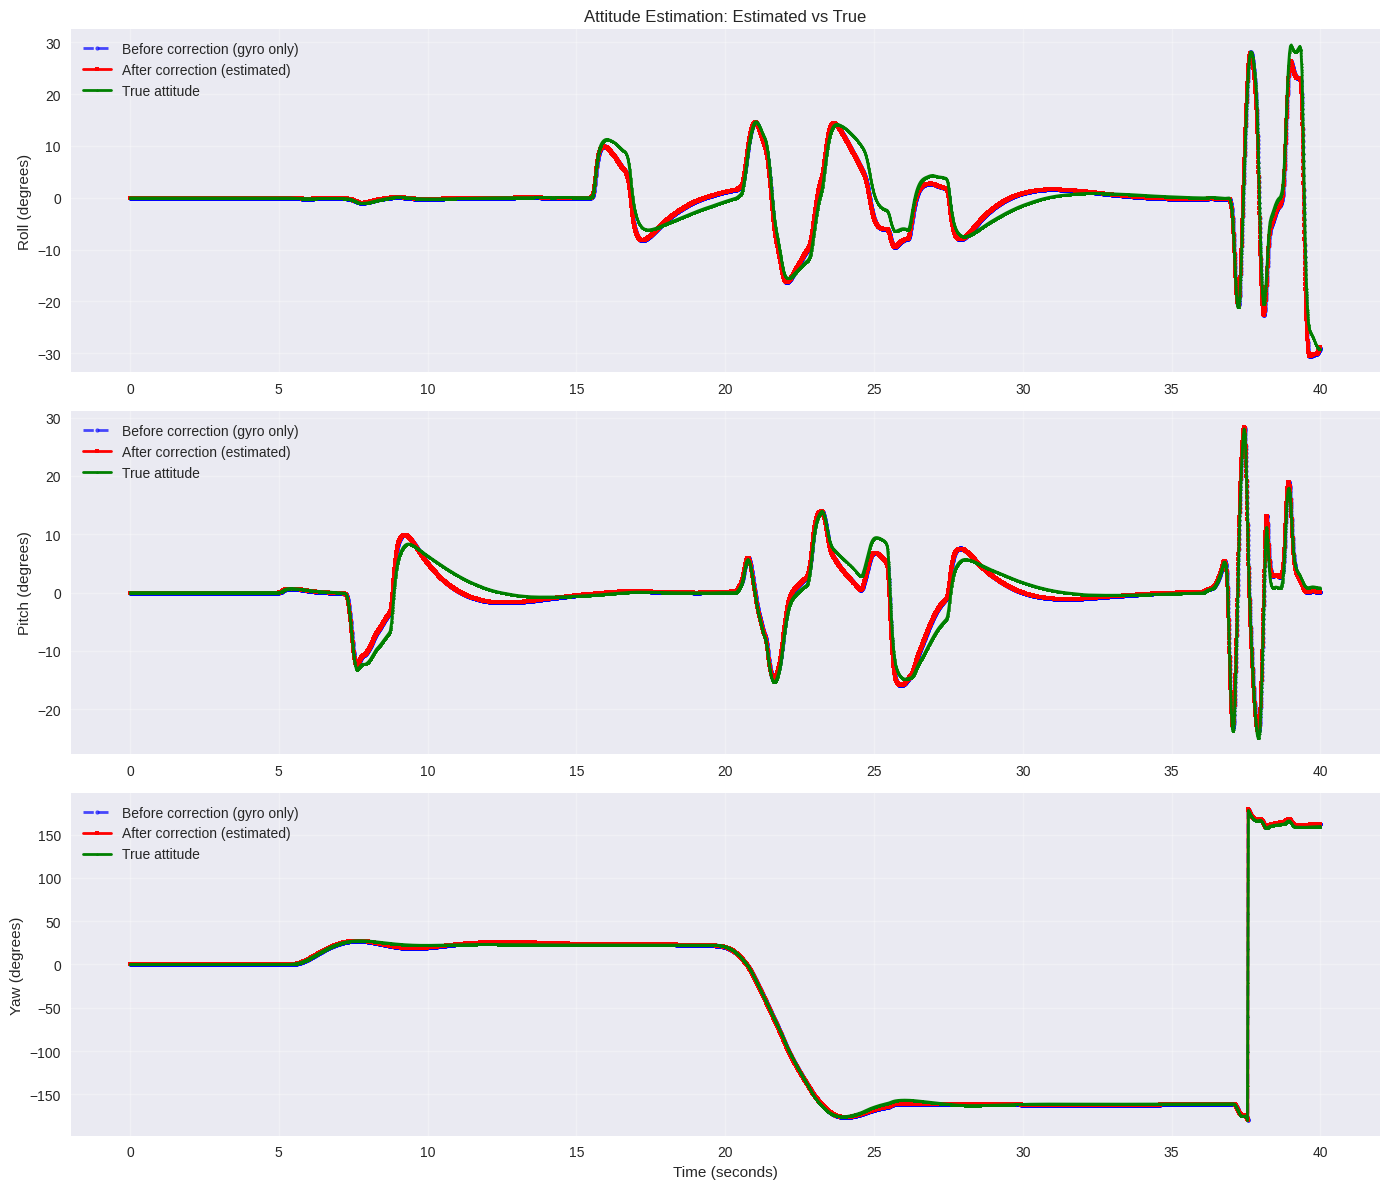

In [14]:
if 'time_array' in locals():
    # Plot attitude comparison
    fig, axes = plt.subplots(3, 1, figsize=(14, 12))
    
    # Roll
    axes[0].plot(time_array, euler_before[:, 0], 'b--o', label='Before correction (gyro only)', 
                linewidth=2, markersize=3, alpha=0.7)
    axes[0].plot(time_array, euler_after[:, 0], 'r-s', label='After correction (estimated)', 
                linewidth=2, markersize=3)
    axes[0].plot(time_array, true_attitude_interp['roll'].iloc[:len(time_array)], 'g-^', 
                label='True attitude', linewidth=2, markersize=2)
    axes[0].set_ylabel('Roll (degrees)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].set_title('Attitude Estimation: Estimated vs True')
    
    # Pitch
    axes[1].plot(time_array, euler_before[:, 1], 'b--o', label='Before correction (gyro only)', 
                linewidth=2, markersize=3, alpha=0.7)
    axes[1].plot(time_array, euler_after[:, 1], 'r-s', label='After correction (estimated)', 
                linewidth=2, markersize=3)
    axes[1].plot(time_array, true_attitude_interp['pitch'].iloc[:len(time_array)], 'g-^', 
                label='True attitude', linewidth=2, markersize=2)
    axes[1].set_ylabel('Pitch (degrees)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Yaw
    axes[2].plot(time_array, euler_before[:, 2], 'b--o', label='Before correction (gyro only)', 
                linewidth=2, markersize=3, alpha=0.7)
    axes[2].plot(time_array, euler_after[:, 2], 'r-s', label='After correction (estimated)', 
                linewidth=2, markersize=3)
    axes[2].plot(time_array, true_attitude_interp['yaw'].iloc[:len(time_array)], 'g-^', 
                label='True attitude', linewidth=2, markersize=2)
    axes[2].set_ylabel('Yaw (degrees)')
    axes[2].set_xlabel('Time (seconds)')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No results to plot!")


In [15]:
## Error Analysis: Estimated vs True Attitude


Removed 14 problematic points, keeping 9986 clean points
=== ATTITUDE ESTIMATION ERROR STATISTICS ===
\nAfter Correction (Clean Data):
  Roll : Mean =  -0.26°, Std =   1.61°, RMS =   1.63°
  Pitch: Mean =  -0.08°, Std =   1.31°, RMS =   1.31°
  Yaw  : Mean =  -0.05°, Std =   1.56°, RMS =   1.56°


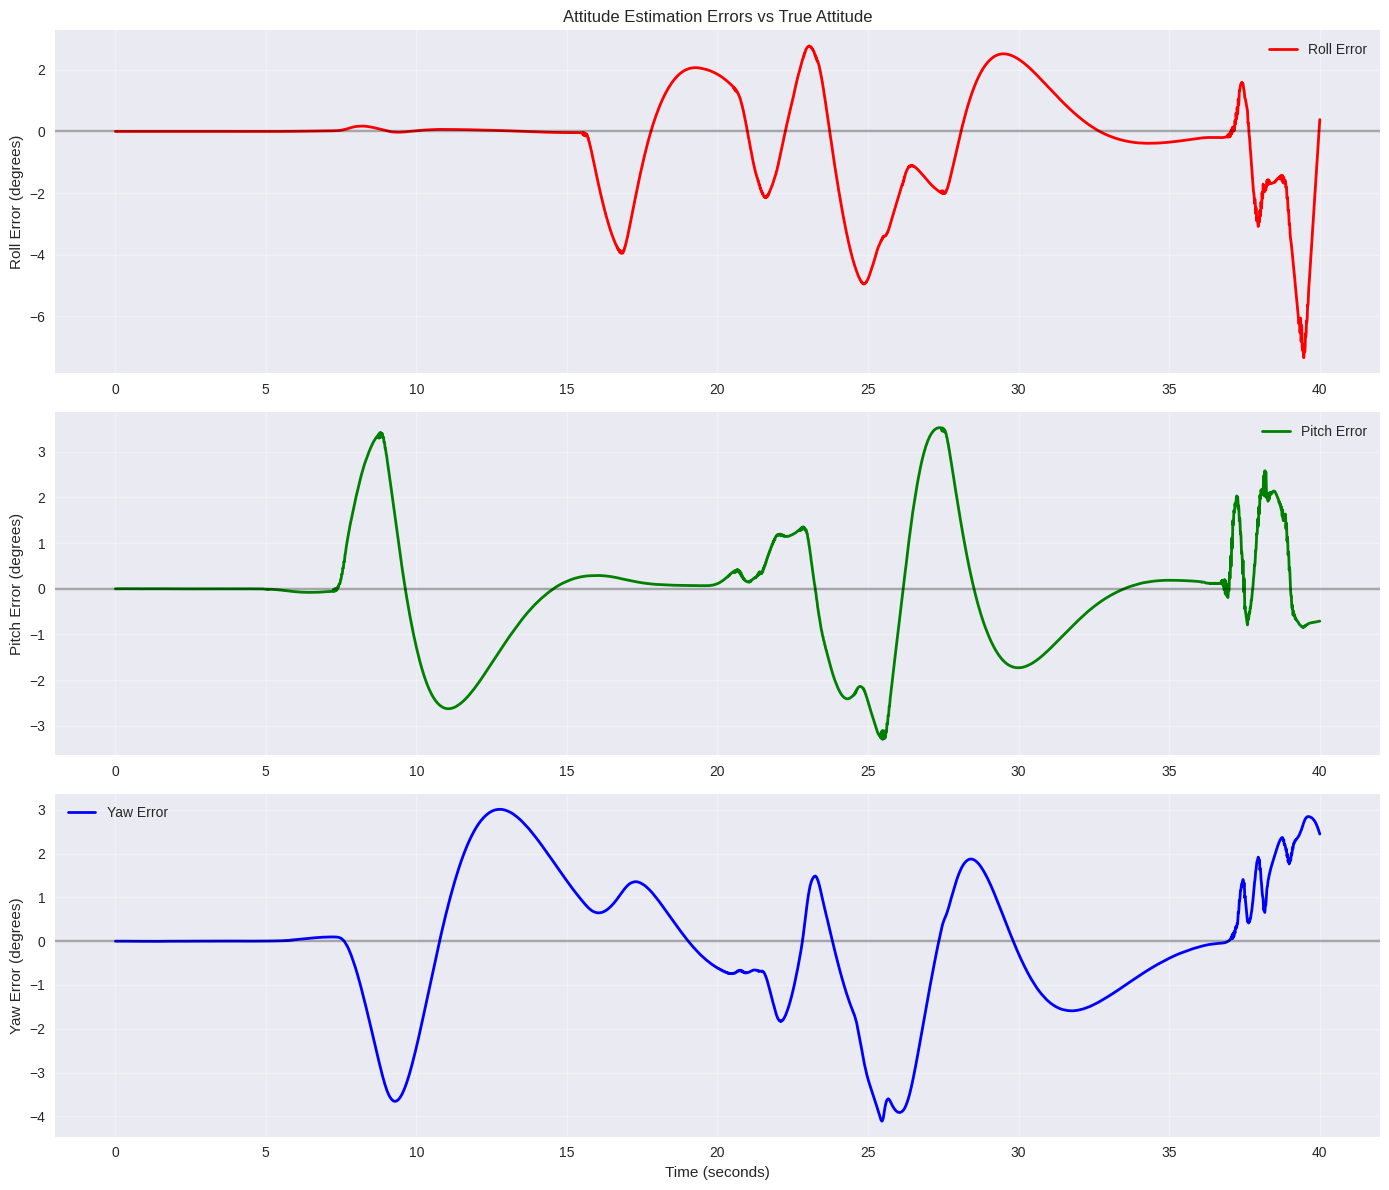

In [16]:
if 'time_array' in locals():
    # Calculate errors between estimated and true attitudes
    true_euler = np.array([
        true_attitude_interp['roll'].iloc[:len(time_array)].values,
        true_attitude_interp['pitch'].iloc[:len(time_array)].values, 
        true_attitude_interp['yaw'].iloc[:len(time_array)].values
    ]).T
    
    # Calculate errors (estimated - true)
    error_after = euler_after - true_euler
    
    # Handle angle wrapping for yaw errors (wrap to [-180, 180])
    def wrap_angle_degrees(angles):
        """Wrap angles to [-180, 180] degrees"""
        return np.mod(angles + 180, 360) - 180
    
    def detect_yaw_discontinuities(yaw_errors, threshold=150):
        """Detect points where yaw error jumps > threshold degrees between consecutive samples"""
        if len(yaw_errors) < 2:
            return np.ones(len(yaw_errors), dtype=bool)
        
        yaw_diff = np.abs(np.diff(yaw_errors))
        large_jumps = yaw_diff > threshold
        
        valid_mask = np.ones(len(yaw_errors), dtype=bool)
        jump_indices = np.where(large_jumps)[0]
        
        for idx in jump_indices:
            # Mark points around the jump as invalid
            start_idx = max(0, idx - 1)
            end_idx = min(len(valid_mask), idx + 3)
            valid_mask[start_idx:end_idx] = False
        
        return valid_mask
    
    def detect_unwrapping_issues(estimated_yaw, true_yaw, threshold=150):
        """Detect unwrapping issues by looking for sudden jumps in either signal"""
        est_jumps = np.abs(np.diff(estimated_yaw)) > threshold
        true_jumps = np.abs(np.diff(true_yaw)) > threshold
        
        valid_mask = np.ones(len(estimated_yaw), dtype=bool)
        all_jumps = np.where(np.logical_or(est_jumps, true_jumps))[0]
        
        for idx in all_jumps:
            start_idx = max(0, idx - 2)
            end_idx = min(len(valid_mask), idx + 4)
            valid_mask[start_idx:end_idx] = False
        
        return valid_mask
    
    # Wrap yaw errors
    error_after[:, 2] = wrap_angle_degrees(error_after[:, 2])
    
    # Create combined mask for all problematic points
    yaw_discontinuity_mask = detect_yaw_discontinuities(error_after[:, 2], threshold=150)
    yaw_unwrapping_mask = detect_unwrapping_issues(euler_after[:, 2], true_euler[:, 2], threshold=30)
    yaw_magnitude_mask = np.abs(error_after[:, 2]) < 170
    
    # Combined mask - keep only clean points
    valid_mask = np.logical_and.reduce([
        yaw_discontinuity_mask, 
        yaw_unwrapping_mask, 
        yaw_magnitude_mask,
    ])
    
    # Filter all data arrays to keep only valid points
    time_array = time_array[valid_mask]
    error_after = error_after[valid_mask]
    euler_after = euler_after[valid_mask]
    true_euler = true_euler[valid_mask]
    
    print(f"Removed {np.sum(~valid_mask)} problematic points, keeping {len(time_array)} clean points")
    
    # Calculate clean statistics
    labels = ['Roll', 'Pitch', 'Yaw']
    
    print("=== ATTITUDE ESTIMATION ERROR STATISTICS ===")
    print("\\nAfter Correction (Clean Data):")
    for i, label in enumerate(labels):
        mean_error = np.mean(error_after[:, i])
        std_error = np.std(error_after[:, i])
        rms_error = np.sqrt(np.mean(error_after[:, i]**2))
        print(f"  {label:5}: Mean = {mean_error:6.2f}°, Std = {std_error:6.2f}°, RMS = {rms_error:6.2f}°")

    # Plot clean results
    fig, axes = plt.subplots(3, 1, figsize=(14, 12))
    
    # Roll error
    axes[0].plot(time_array, error_after[:, 0], 'r-', label='Roll Error', linewidth=2)
    axes[0].axhline(y=0, color='k', linestyle='-', alpha=0.3)
    axes[0].set_ylabel('Roll Error (degrees)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].set_title('Attitude Estimation Errors vs True Attitude')
    
    # Pitch error
    axes[1].plot(time_array, error_after[:, 1], 'g-', label='Pitch Error', linewidth=2)
    axes[1].axhline(y=0, color='k', linestyle='-', alpha=0.3)
    axes[1].set_ylabel('Pitch Error (degrees)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Yaw error
    axes[2].plot(time_array, error_after[:, 2], 'b-', label='Yaw Error', linewidth=2)
    axes[2].axhline(y=0, color='k', linestyle='-', alpha=0.3)
    axes[2].set_ylabel('Yaw Error (degrees)')
    axes[2].set_xlabel('Time (seconds)')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    #axes[2].set_ylim(-10, 10)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("No results to analyze!")

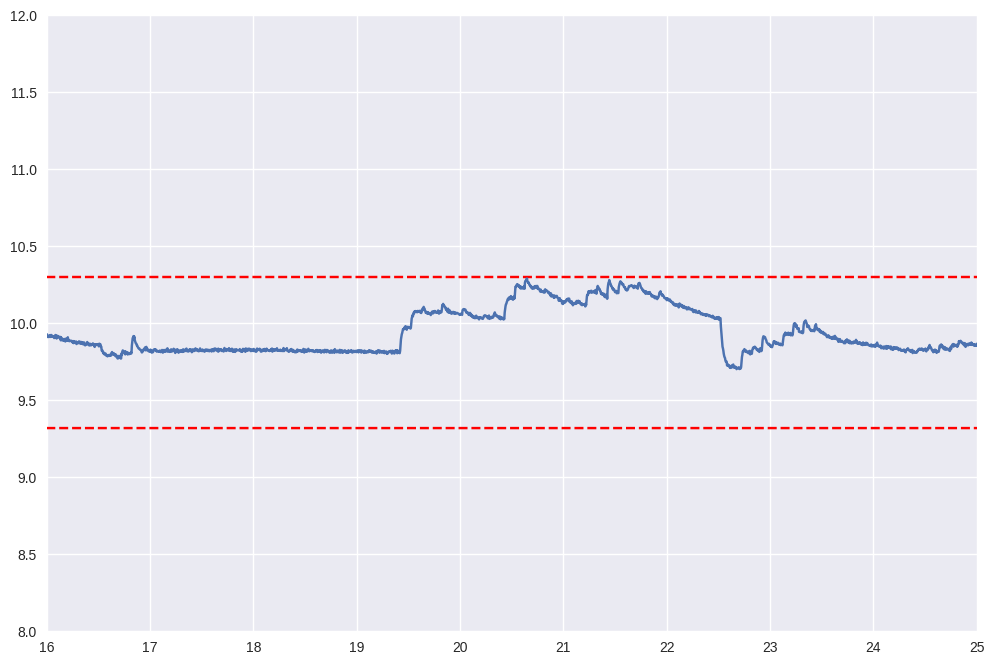

In [17]:
threshold = 0.05
accel_norm = np.sqrt(imu_data['accel_x']**2 + imu_data['accel_y']**2 + imu_data['accel_z']**2)
g_high = 9.81 * (1.0 + threshold)
g_low = 9.81 * (1.0 - threshold)
plt.plot(imu_data['timestamp'], g_high * np.ones(len(imu_data['timestamp'])), 'r--')
plt.plot(imu_data['timestamp'], g_low * np.ones(len(imu_data['timestamp'])), 'r--')
plt.plot(imu_data['timestamp'], accel_norm)
plt.xlim(16, 25)
plt.ylim(8, 12)
plt.show()
